In [18]:
import os

import pywt
import numpy as np
import scipy.signal.spectral as sss
import tensorflow as tf
#from PIL import Image
# import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
# 一共获取1000组数据，每组数据尺寸为512，采样的步长为180；
def get_batch(filename, window_size=512, batch_size=1000, stride=180):
    data = np.loadtxt(filename)
    start = 0
    cnt = 0
    batch_data = []
    while start + window_size < data.shape[0] and cnt < batch_size:
        batch_data.append(data[start: start + window_size])
        start = start + stride + 1
        cnt += 1
    batch_data = np.array(batch_data)
    return batch_data

In [20]:
def batch2image(signal_batch, sampling_rate, pooling_size, process_type='wavelet'):
    """
    批数据转换成图片
    :signal_batch:
    :sampling_rate:
    :pooling_size:
    :process_type:
    :return:
    """
    num, dim = np.shape(signal_batch)
    batch_set = []
    if process_type == 'wavelet':
        for i in range(num):
            image, _ = wavelet2image(signal_batch[i, :], sampling_rate)
            batch_set.append(image)
    elif process_type == 'stft':
        for i in range(num):
            image, _ = stft2image(signal_batch[i, :], sampling_rate)
            batch_set.append(image)
    else:
        raise KeyError("process_type must be wavelet of stft!")
    batch_set = np.array(batch_set)
    batch_set = image_downsampling(batch_set, pooling_size, form='avg_pooling')

    return batch_set

In [21]:
def wavelet2image(signal, sampling_rate, freq_dim_scale=256, wavelet_name='morl'):

    """
    小波图像
    :param signal: 1D temporal sequence
    :param sampling_rate: sampling rate for the sequence  定义了每秒从连续信号中提取并组成离散信号的采样个数
    :param freq_dim_scale: frequency resolution  目的是避免信号混淆保证高频信号不被歪曲成低频信号
    :param wavelet_name: wavelet name for CWT, here we have 'morl', 'gaus', 'cmor',...
    :return: time-freq image and its reciprocal frequencies  时频图像及其倒数频率
    """

    freq_centre = pywt.central_frequency(wavelet_name)            # 所选小波的中心频率
    cparam = 2 * freq_centre * freq_dim_scale
    scales = cparam / np.arange(1, freq_dim_scale + 1, 1)         # 获取小波基函数的尺度参数 a 的倒数
    [cwt_matrix, frequencies] = pywt.cwt(signal, scales, wavelet_name, 1.0 / sampling_rate)

    return abs(cwt_matrix), frequencies

In [22]:
def stft2image(signal, sampling_rate, freq_dim_scale=256, window_name=('gaussian', 3.0)):

    """
    :param signal: signal input for stft
    :param sampling_rate:
    :param window_name: (gaussian,3), hann, hamming, etc.

    Notes
    -----
    Window types:

        `boxcar`, `triang`, `blackman`, `hamming`, `hann`, `bartlett`,
        `flattop`, `parzen`, `bohman`, `blackmanharris`, `nuttall`,
        `barthann`, `kaiser` (needs beta), `gaussian` (needs standard
        deviation), `general_gaussian` (needs power, width), `slepian`
        (needs width), `dpss` (needs normalized half-bandwidth),
        `chebwin` (needs attenuation), `exponential` (needs decay scale),
        `tukey` (needs taper fraction)

    :return: time-freq image and its frequencies
    """

    f, t, Zxx = sss.stft(signal, fs=sampling_rate, window=window_name, nperseg=freq_dim_scale)

    return Zxx, f

In [1]:
def image_downsampling(image_set, pooling_size=2, form='max_pooling', axis=None):

    """
    :param image_set: input image with large size
    :param pooling_size: down-sampling rate
    :param form: 'max_pooling' or 'avg_pooling'
    :param axis: if axis is not None, it means that the image will be down-sampled
                 just within it row(axis=0) or column(axis=1).
    :return: image has been down-sampled
    """

    num, time_dim, freq_dim = np.shape(image_set)[0], np.shape(image_set)[1], np.shape(image_set)[2]
    image_set = image_set.reshape(num, time_dim, freq_dim, 1)
    im_input = tf.placeholder(dtype=tf.float32, shape=[num, time_dim, freq_dim, 1])
    kernel_size = [pooling_size, 2*pooling_size]
    if axis == 0:
        kernel_size = [pooling_size, 1]
    elif axis == 1:
        kernel_size = [1, pooling_size]

    with tf.device('/gpu:0'):
        pooling_max = tf.contrib.slim.max_pool2d(im_input, kernel_size=kernel_size, stride=kernel_size)
        pooling_avg = tf.contrib.slim.avg_pool2d(im_input, kernel_size=kernel_size, stride=kernel_size)

    with tf.Session() as sess:
        down_sampling_im = sess.run(fetches=pooling_max, feed_dict={im_input: image_set})
        if form == 'avg_pooling':
            down_sampling_im = sess.run(fetches=pooling_avg, feed_dict={im_input: image_set})

    return down_sampling_im

In [56]:
#从tex文件夹中遍历故障数据文件、设置输出路径
for root, dirs, files in os.walk("./data/preprocess/txt"):
    print(files)
output_path = './data/preprocess/wave_images'
if not os.path.exists(output_path):
    os.makedirs(output_path)

['fault_data_0HP_BF.txt', 'fault_data_0HP_IB.txt', 'fault_data_0HP_IF.txt', 'fault_data_0HP_IO.txt', 'fault_data_0HP_IOB.txt', 'fault_data_0HP_OB.txt', 'fault_data_0HP_OF.txt']


In [25]:
#枚举files、对数据进行小波变换处理
for i, file in enumerate(files):
    print("processing %s" % file)
    c = file.split('_')[0] if "normal" in file else file.split('_')[3]
    label = "{}_{}".format(c, i)
    print(label)
    file_path = os.path.join(root, file) # 路径拼接：根目录+file路径
    print(file_path)
    signal = get_batch(filename=file_path, batch_size=2000) # 未指定窗口大小和步长即为默认值
    batch_image = batch2image(signal, sampling_rate=1, pooling_size=4)
    print("saving %s/%s.npy, shape %s" % (output_path, label, batch_image.shape))
    np.save("%s/%s.npy" % (output_path, label), batch_image)

processing fault_data_0HP_BF.txt
BF.txt_0
./data/train/txt\fault_data_0HP_BF.txt
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

saving ./data/train/wave_images/BF.txt_0.npy, shape (2000, 64, 64, 1)
processing fault_data_0HP_IB.txt
IB.txt_1
./data/train/txt\fault_data_0HP_IB.txt
saving ./data/train/wave_images/IB.txt_1.npy, shape (2000, 64, 64, 1)
processing fault_data_0HP_IF.txt
IF.txt_2
./data/train/txt\fault_data_0HP_IF.txt
saving ./data/train/wave_images/IF.txt_2.npy, shape (2000, 64, 64, 1)
processing fault_data_0HP_IO.txt
IO.txt_3
./data/train/txt\fault_data_0HP_IO.txt


saving ./data/train/wave_images/IO.txt_3.npy, shape (2000, 64, 64, 1)
processing fault_data_0HP_IOB.txt
IOB.txt_4
./data/train/txt\fault_data_0HP_IOB.txt
saving ./data/train/wave_images/IOB.txt_4.npy, shape (2000, 64, 64, 1)
processing fault_data_0HP_OF.txt
OF.txt_5
./data/train/txt\fault_data_0HP_OF.txt
saving ./data/train/wave_images/OF.txt_5.npy, shape (2000, 64, 64, 1)
processing fault_data_0HP_OR.txt
OR.txt_6
./data/train/txt\fault_data_0HP_OR.txt
saving ./data/train/wave_images/OR.txt_6.npy, shape (2000, 64, 64, 1)


In [54]:
#载入7种故障类型的数据集

#训练数据集
IF=np.load("./data/preprocess/wave_images/IF.txt_2.npy")
OF=np.load("./data/preprocess/wave_images/OF.txt_5.npy")
BF=np.load("./data/preprocess/wave_images/BF.txt_0.npy")
#测试数据集
IB=np.load("./data/preprocess/wave_images/IB.txt_1.npy")
IO=np.load("./data/preprocess/wave_images/IO.txt_3.npy")
OB=np.load("./data/preprocess/wave_images/OB.txt_6.npy")
IOB=np.load("./data/preprocess/wave_images/IOB.txt_4.npy")

内圈：


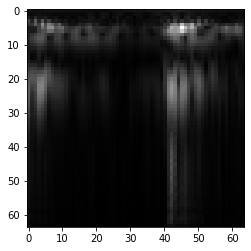

外圈：


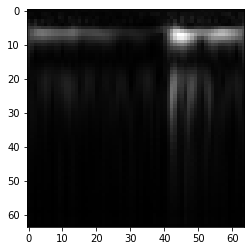

滚子：


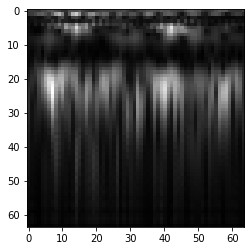

内外圈：


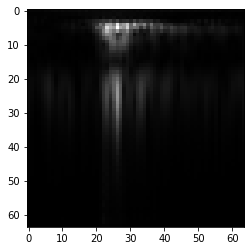

内圈滚子：


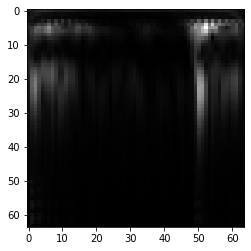

外圈滚子：


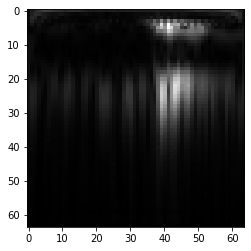

内外滚：


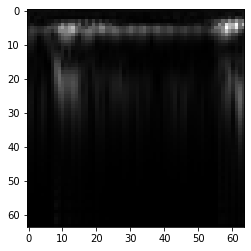

In [55]:
#I-内圈 O-外圈 B-滚子

import matplotlib.pyplot as pyplot 
#内圈
print("内圈：")
plt.imshow(IF[0], cmap = plt.get_cmap('gray'))
plt.show()
#外圈
print("外圈：")
plt.imshow(OF[0], cmap = plt.get_cmap('gray'))
plt.show()
#滚子
print("滚子：")
plt.imshow(BF[0], cmap = plt.get_cmap('gray'))
plt.show()
#内外圈
print("内外圈：")
plt.imshow(IO[0], cmap = plt.get_cmap('gray'))
plt.show()
#内圈滚子
print("内圈滚子：")
plt.imshow(IB[0], cmap = plt.get_cmap('gray'))
plt.show()
#外圈滚子
print("外圈滚子：")
plt.imshow(OB[0], cmap = plt.get_cmap('gray'))
plt.show()
#内外滚
print("内外滚：")
plt.imshow(IOB[0], cmap = plt.get_cmap('gray'))
plt.show()


In [69]:
import scipy.io
import numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline
from keras.utils import plot_model
from keras.utils import np_utils

In [70]:
# 创建训练数据集
def creat_train_dataset(select):
    x_all = []
    y_all = []
    for elem in select:
        print(elem[0])
#        sig = df[elem[0]]
      #  print(len(sig))
        if elem[1] == 0:
            sig =np.load("./data/preprocess/wave_images/IF.txt_2.npy")
        elif elem[1] == 1:
            sig =np.load("./data/preprocess/wave_images/OF.txt_5.npy")
        else:
            sig =np.load("./data/preprocess/wave_images/BF.txt_0.npy")
      #  i = i+1   
        x = sig
        label = elem[1]

        print(x.shape)
      #  print(x.shape[0])
        x_all.append(x)
        y = [[label] for _ in range(x.shape[0])]
        y_all.append(y)
    x_merge = np.vstack(x_all)
    y_merge = np.vstack(y_all)
#     print(x_all)
#     print(x_merge)
#     print(y_all)
#     print(y_merge)
    return x_merge, y_merge

In [73]:
# 创建测试数据集
def creat_test_dataset(select):
    x_all = []
    y_all = []
    i=0
    for elem in select:
        print(elem[0])
#        sig = df[elem[0]]
      #  print(len(sig))
        if elem[1] == 0:
            sig =np.load("./data/preprocess/wave_images/IO.txt_3.npy")
        elif elem[1] == 1:
            sig =np.load("./data/preprocess/wave_images/IB.txt_1.npy")
        
        elif elem[1] == 2:
            sig =np.load("./data/preprocess/wave_images/OB.txt_6.npy")
        else:
            sig =np.load("./data/preprocess/wave_images/IOB.txt_4.npy")
      #  i = i+1   
        label = elem[1]
        x = sig
        print(x.shape)
      #  print(x.shape[0])
        x_all.append(x)
        y = [[label] for _ in range(x.shape[0])]
        y_all.append(y)
    x_merge = np.vstack(x_all)
    y_merge = np.vstack(y_all)
#     print(x_all)
#     print(x_merge)
#     print(y_all)
#     print(y_merge)
    return x_merge, y_merge

In [74]:
data_train = [('IF',0), ('OF', 1), ('BF', 2)]
data_test  = [('IO',0), ('IB', 1), ('OB', 2),('IOB', 3)]

In [75]:
x_train, y_train = creat_train_dataset(select=data_train)
x_test, y_test = creat_test_dataset(select=data_test)

IF
(2000, 64, 64, 1)
OF
(2000, 64, 64, 1)
BF
(2000, 64, 64, 1)
IO
(2000, 64, 64, 1)
IB
(2000, 64, 64, 1)
OB
(2000, 64, 64, 1)
IOB
(2000, 64, 64, 1)


In [76]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(6000, 64, 64, 1)
(6000, 1)
(8000, 64, 64, 1)
(8000, 1)


In [79]:
y_train1 = keras.utils.to_categorical(y_train, num_classes=3)
print(y_train1.shape)

(6000, 3)


In [78]:
np.save('./data/train/x_trian', x_train)
np.save('./data/train/y_train', y_train)
np.save('./data/test/x_test', x_test)
np.save('./data/test/y_test', y_test)